### **1. Visualize the normal and tumor training images**

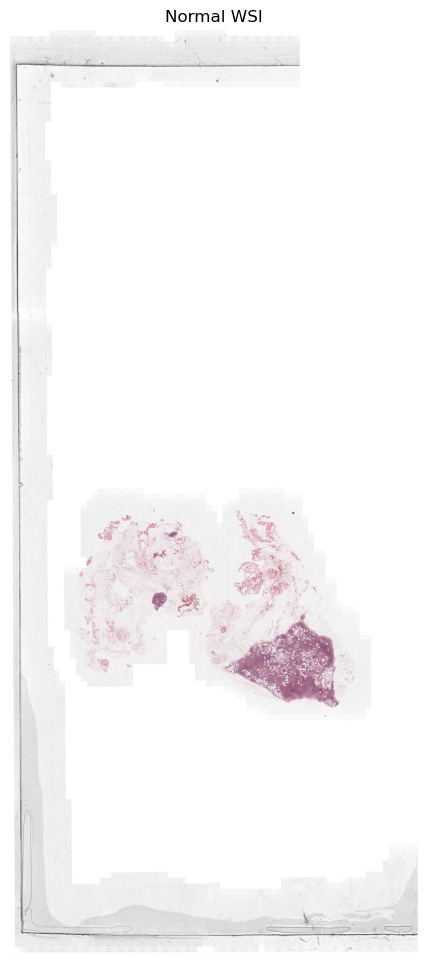

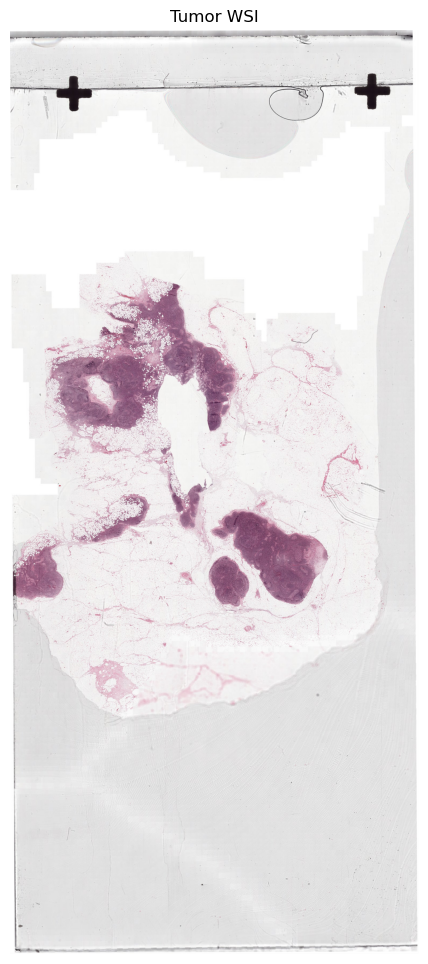

In [4]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os
os.add_dll_directory(r"C:\Program Files\OpenSlide\openslide-bin-4.0.0.8-windows-x64\bin")

from openslide import OpenSlide

def show_wsi_thumbnail(wsi_path, thumbnail_size=(2048, 2048), title=""):
    slide = OpenSlide(wsi_path)
    thumbnail = slide.get_thumbnail(thumbnail_size)

    plt.figure(figsize=(12, 12))
    plt.imshow(thumbnail)
    plt.title(title)
    plt.axis("off")
    plt.show()

normal_path = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img", "normal_002.tif")
tumor_path = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img", "tumor_001.tif")

show_wsi_thumbnail(normal_path, title="Normal WSI")
show_wsi_thumbnail(tumor_path, title="Tumor WSI")

# Save thumbnails as PNG files
thumbnail_normal = OpenSlide(normal_path).get_thumbnail((2048, 2048)).save("normal_thumbnail.png")
thumbnail_tumor = OpenSlide(tumor_path).get_thumbnail((2048, 2048)).save("tumor_thumbnail.png")


In [ ]:
import zipfile

def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    else:
        print(f"[INFO] Directory of destination already exists. Skipping extraction.")
        return
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"[INFO] Extracted {zip_path} to {extract_to}")

zip_path = os.path.join(os.getcwd(), "..", "data", "camelyon16", "masks", "lesion_annotations.zip")
extract_to = os.path.join(os.getcwd(), "..", "data", "camelyon16", "masks", "annotations")
extract_zip(zip_path, extract_to)


[INFO] Directory c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\masks\annotations already exists. Skipping extraction.


### **2. Parsing the XML mask**

In [6]:
from lxml import etree

def parse_xml_annotation(xml_path):
    """
    Parse the XML annotation file and extract regions of tumor.
    Parameters:
        xml_path (str): Path to the XML annotation file.
    """

    tree = etree.parse(xml_path)
    coordinates = []
    for region in tree.xpath("//Annotation/Regions/Region/Vertices"):
        coords = []
        for vertex in region.xpath(".//Vertex"):
            x = float(vertex.attrib["X"])
            y = float(vertex.attrib["Y"])
            coords.append((x, y))
        coordinates.append(coords)
    return coordinates




### **3. Overlaying the mask on the WSI**

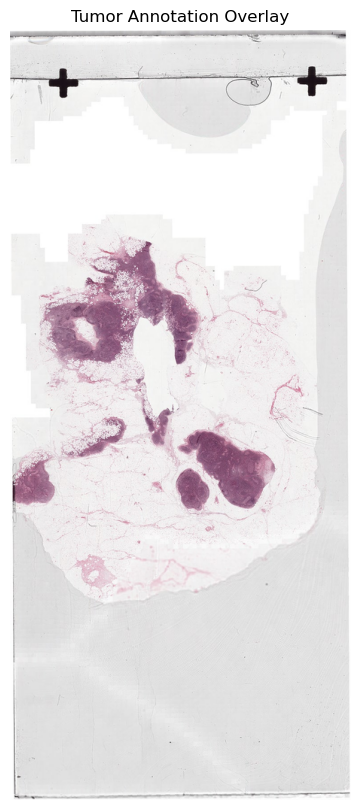

In [7]:
import matplotlib.pyplot as plt
os.add_dll_directory(r"C:\Program Files\OpenSlide\openslide-bin-4.0.0.8-windows-x64\bin")
from openslide import OpenSlide

def show_mask_overlay(wsi_path, xml_path, level=4):
    slide = OpenSlide(wsi_path)
    thumb = slide.get_thumbnail((1024, 1024))
    w, h = slide.dimensions
    coords = parse_xml_annotation(xml_path)

    # Scale coordinates to thumbnail
    scale_x = 1024 / w
    scale_y = 1024 / h

    # Visualize
    plt.figure(figsize=(10, 10))
    plt.imshow(thumb)
    for region in coords:
        xs, ys = zip(*region)
        xs = [x * scale_x for x in xs]
        ys = [y * scale_y for y in ys]
        plt.plot(xs, ys, 'r-', linewidth=2)
    plt.title("Tumor Annotation Overlay")
    plt.axis('off')
    plt.show()

wsi_path = tumor_path
xml_path = os.path.join(os.getcwd(), "..", "data", "camelyon16", "masks", "annotations", "tumor_001.xml")
show_mask_overlay(wsi_path, xml_path)
thumb = OpenSlide(wsi_path).get_thumbnail((2048, 2048))
thumb.save("tumor_mask_overlay.png")


## **Convert mask and images to tensor**

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Define transformations for images and masks
image_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Resize((512, 512))  # Resize to a fixed size
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert mask to tensor
    transforms.Resize((512, 512)),  # Resize to match image size
    transforms.Lambda(lambda x: (x > 0).float())  # Convert mask to binary (0 or 1)
])

def preprocess_image(image_path, transform):
    image = Image.open(image_path)
    return transform(image)

def preprocess_mask(mask_path, transform):
    mask = Image.open(mask_path)
    return transform(mask)

In [ ]:
from torch.utils.data import Dataset

class CamelyonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".tif")]
        self.mask_files = [f.replace(".tif", ".png") for f in self.image_files]  # Assuming masks are PNG files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = preprocess_image(image_path, self.image_transform)
        mask = preprocess_mask(mask_path, self.mask_transform)
        return image, mask

In [ ]:
from torch.utils.data import DataLoader

train_image_dir = "./data/camelyon16/train/img"
train_mask_dir = "./data/camelyon16/masks"

train_dataset = CamelyonDataset(train_image_dir, train_mask_dir, image_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Test the dataloader
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break

In [ ]:
# Size in bytes of normal_002.tif (width and height)
normal_path = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img", "normal_005.tif")
width, height = OpenSlide(normal_path).dimensions
print(f"Normal WSI dimensions: {width}x{height}")
normal_size = os.path.getsize(normal_path)
normal_size

# find biggest WSI in the training set
import glob
wsi_files = glob.glob(os.path.join(os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img"), "*.tif"))
biggest_wsi = max(wsi_files, key=os.path.getsize)
biggest_wsi_size = os.path.getsize(biggest_wsi)
print(f"Biggest WSI: {biggest_wsi}, Size: {biggest_wsi_size} bytes")
# measure the size in bytes of tumor_001.tif (width and height)
width, height = OpenSlide(tumor_path).dimensions
print(f"Tumor WSI dimensions: {width}x{height}")

Normal WSI dimensions: 97792x221184
Biggest WSI: c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\train\img\tumor_001.tif, Size: 3264779514 bytes
Tumor WSI dimensions: 97792x221184
